In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv001.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/IPMI-2023


In [2]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [3]:
%autoreload
bioqic = mre_pinn.data.BIOQICFEMBox('../data/BIOQIC/downloads')
bioqic.download()
bioqic.load_mat()
bioqic.preprocess()
dataset = bioqic.to_dataset()
dataset.save_xarrays('../data/BIOQIC/fem_box')

Loading ../data/BIOQIC/downloads/four_target_phantom.mat
    __header__: <class 'bytes'>
    __version__: <class 'str'>
    __globals__: <class 'list'>
    u_ft: <class 'numpy.ndarray'> (100, 80, 10, 3, 6) complex128
<xarray.Dataset>
Dimensions:    (frequency: 6, x: 80, y: 100, z: 10, component: 3)
Coordinates:
  * frequency  (frequency) int64 50 60 70 80 90 100
  * x          (x) float64 0.0 0.001 0.002 0.003 ... 0.076 0.077 0.078 0.079
  * y          (y) float64 0.0 0.001 0.002 0.003 ... 0.096 0.097 0.098 0.099
  * z          (z) float64 0.0 0.001 0.002 0.003 ... 0.006 0.007 0.008 0.009
  * component  (component) <U1 'y' 'x' 'z'
Data variables:
    wave       (frequency, x, y, z, component) complex128 (0.0018039287661982...
Segmenting spatial regions
Creating ground truth elastogram
Writing ../data/BIOQIC/fem_box/50/wave.nc
Writing ../data/BIOQIC/fem_box/50/mre.nc
Writing ../data/BIOQIC/fem_box/50/mre_mask.nc
Writing ../data/BIOQIC/fem_box/60/wave.nc
Writing ../data/BIOQIC/fem_box/60

In [4]:
%autoreload
example = mre_pinn.data.MREExample.load_xarrays('../data/BIOQIC/fem_box', 60)
example.metadata

Loading ../data/BIOQIC/fem_box/60/wave.nc
Loading ../data/BIOQIC/fem_box/60/mre.nc
Loading ../data/BIOQIC/fem_box/60/mre_mask.nc


size  spacing  origin  limit  center  extent
variable dimension                                              
wave     x            80    0.001     0.0  0.079  0.0395    0.08
         y           100    0.001     0.0  0.099  0.0495    0.10
         z            10    0.001     0.0  0.009  0.0045    0.01
mre      x            80    0.001     0.0  0.079  0.0395    0.08
         y           100    0.001     0.0  0.099  0.0495    0.10
         z            10    0.001     0.0  0.009  0.0045    0.01
mre_mask x            80    0.001     0.0  0.079  0.0395    0.08
         y           100    0.001     0.0  0.099  0.0495    0.10
         z            10    0.001     0.0  0.009  0.0045    0.01

In [5]:
example.describe()

dtype    count                     mean          std  \
variable component                                                              
wave     y          complex128  80000.0  -0.00000100-0.00001000j     0.000724   
         x          complex128  80000.0   0.00022200-0.00020700j     0.000742   
         z          complex128  80000.0   0.00092400+0.00005900j     0.012493   
mre      scalar     complex128  80000.0  3382.375000+376.991118j  1590.727619   
mre_mask scalar          int64  80000.0   1.07650000+0.00000000j     0.362143   

                                        min                      25%  \
variable component                                                     
wave     y          -0.00198900-0.00084800j  -0.00031600+0.00029700j   
         x          -0.00271700+0.00009800j  -0.00007000-0.00019200j   
         z          -0.02294100-0.00252200j  -0.00443200-0.00007700j   
mre      scalar     3000.000000+376.991118j  3000.000000+376.991118j   
mre_mask scalar      1.00000000+0.00000000j   1.00000000+0.00000000j   

                                        50%                      75%  \
variable component                                                     
wave     y           0.00002900+0.00024900j   0.00031500+0.00007300j   
         x           0.00017900+0.00008700j   0.00053800-0.00078400j   
         z           0.00069400+0.00010000j   0.00689700-0.01260300j   
mre      scalar     3000.000000+376.991118j  3000.000000+376.991118j   
mre_mask scalar      1.00000000+0.00000000j   1.00000000+0.00000000j   

                                         max  
variable component                            
wave     y          0.001772000+0.000765000j  
         x          0.002784000-0.001559000j  
         z          0.022754000+0.005157000j  
mre      scalar     10000.000000+376.991118j  
mre_mask scalar     5.000000000+0.000000000j

Evaluating direct baseline
Evaluating FEM baseline
100%|██████████| 10/10 [01:44<00:00, 10.48s/it]


<IPython.core.display.Javascript object>


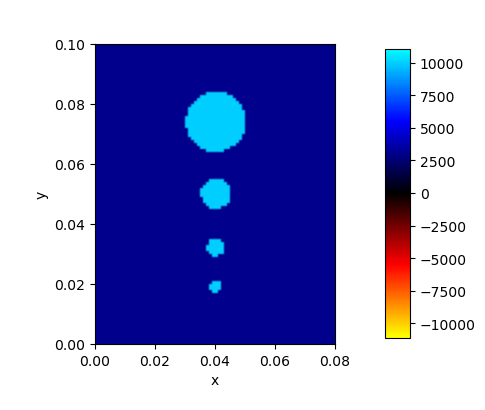

interactive(children=(SelectionSlider(description='part', options=(('abs', 0), ('angle', 1)), value=0), Select…

<IPython.core.display.Javascript object>


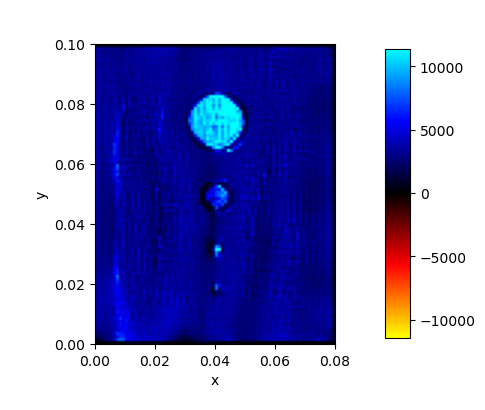

interactive(children=(SelectionSlider(description='part', options=(('abs', 0), ('angle', 1)), value=0), Select…

<IPython.core.display.Javascript object>


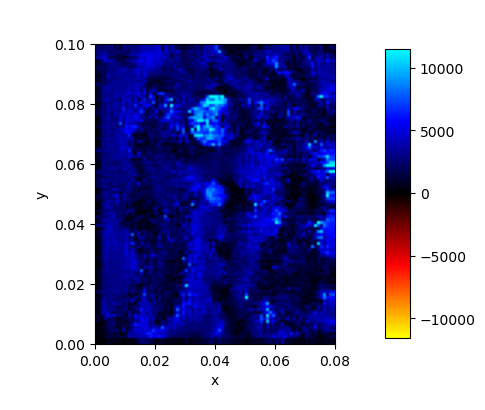

interactive(children=(SelectionSlider(description='part', options=(('abs', 0), ('angle', 1)), value=0), Select…

In [6]:
%autoreload
frequency = example.wave.frequency.item()
mre_pinn.baseline.eval_direct_baseline(example, frequency=frequency)
mre_pinn.baseline.eval_fem_baseline(example, frequency=frequency)
example.view('mre', 'direct', 'fem', ax_height=3, polar=True)

In [76]:
pde = mre_pinn.pde.WaveEquation.from_name('hetero', omega=frequency, detach=True)

In [91]:
%autoreload
pinn = mre_pinn.model.MREPINN(
    example,
    omega=30,
    n_layers=5,
    n_hidden=128,
    polar_input=False,
    conditional=False
)
pinn

MREPINN(
  (u_pinn): PINN(
    (hidden0): Linear(in_features=3, out_features=128, bias=True)
    (hidden1): Linear(in_features=131, out_features=128, bias=True)
    (hidden2): Linear(in_features=259, out_features=128, bias=True)
    (hidden3): Linear(in_features=387, out_features=128, bias=True)
    (output): Linear(in_features=515, out_features=6, bias=True)
  )
  (mu_pinn): PINN(
    (hidden0): Linear(in_features=3, out_features=128, bias=True)
    (hidden1): Linear(in_features=131, out_features=128, bias=True)
    (hidden2): Linear(in_features=259, out_features=128, bias=True)
    (hidden3): Linear(in_features=387, out_features=128, bias=True)
    (output): Linear(in_features=515, out_features=2, bias=True)
  )
)

In [92]:
%autoreload
model = mre_pinn.training.MREPINNModel(
    example, pinn, pde,
    loss_weights=[1, 0, 1e-16],
    pde_warmup_iters=5000,
    pde_step_iters=5000,
    pde_init_weight=1e-18,
    n_points=1024
)
model.compile(optimizer='adam', lr=1e-4, loss=mre_pinn.training.losses.msae_loss)

Compiling model...
'compile' took 0.000222 s



In [93]:
%autoreload
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
model.benchmark(100)

# iterations: 100
Data time/iter:  0.0003s (0.61%)
Model time/iter: 0.0007s (1.18%)
Loss time/iter:  0.0559s (98.21%)
Total time/iter: 0.0570s
Total time: 5.6964s
1k iters time: 0.95m
10k iters time: 9.49m
100k iters time: 1.58h


<IPython.core.display.Javascript object>


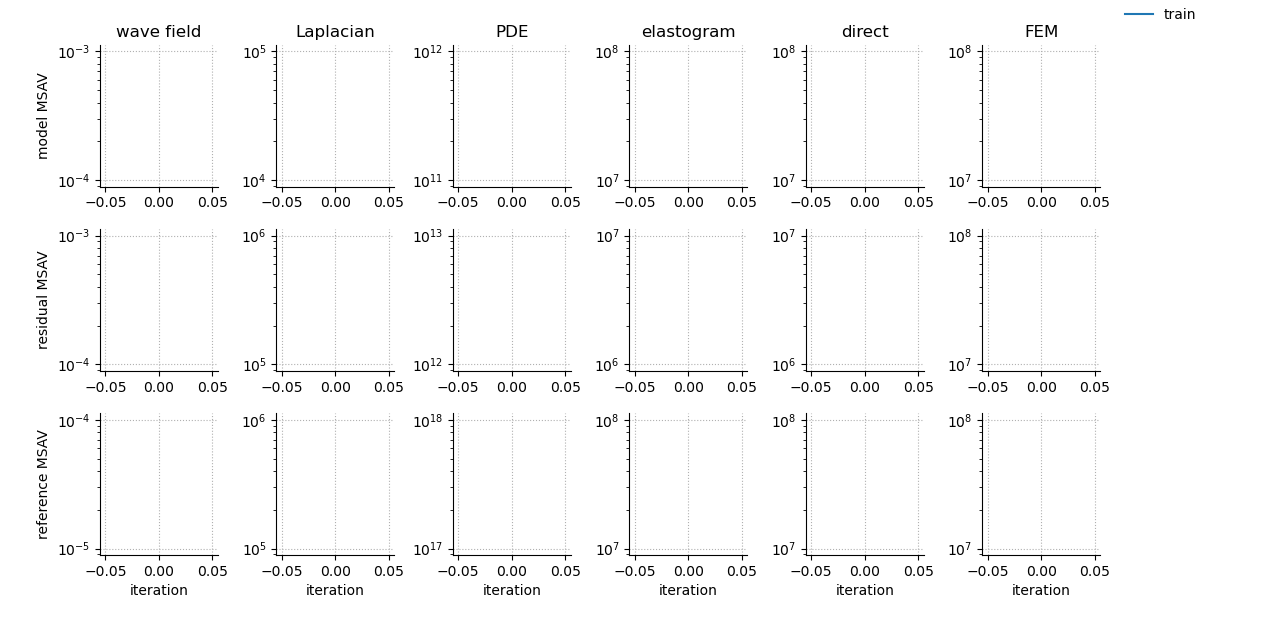

<IPython.core.display.Javascript object>


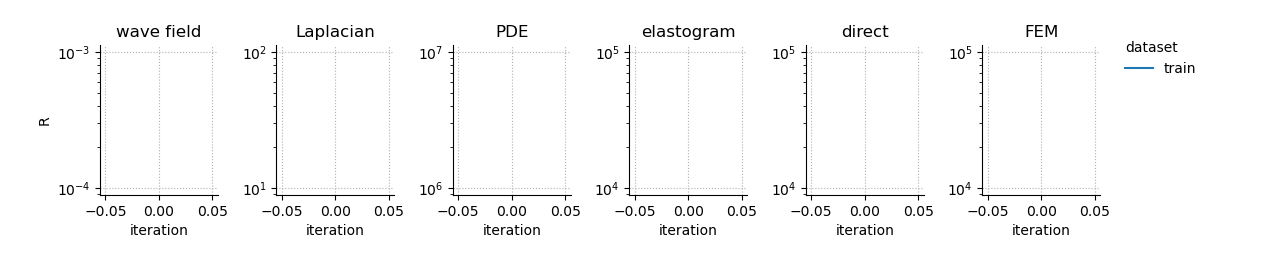

<IPython.core.display.Javascript object>


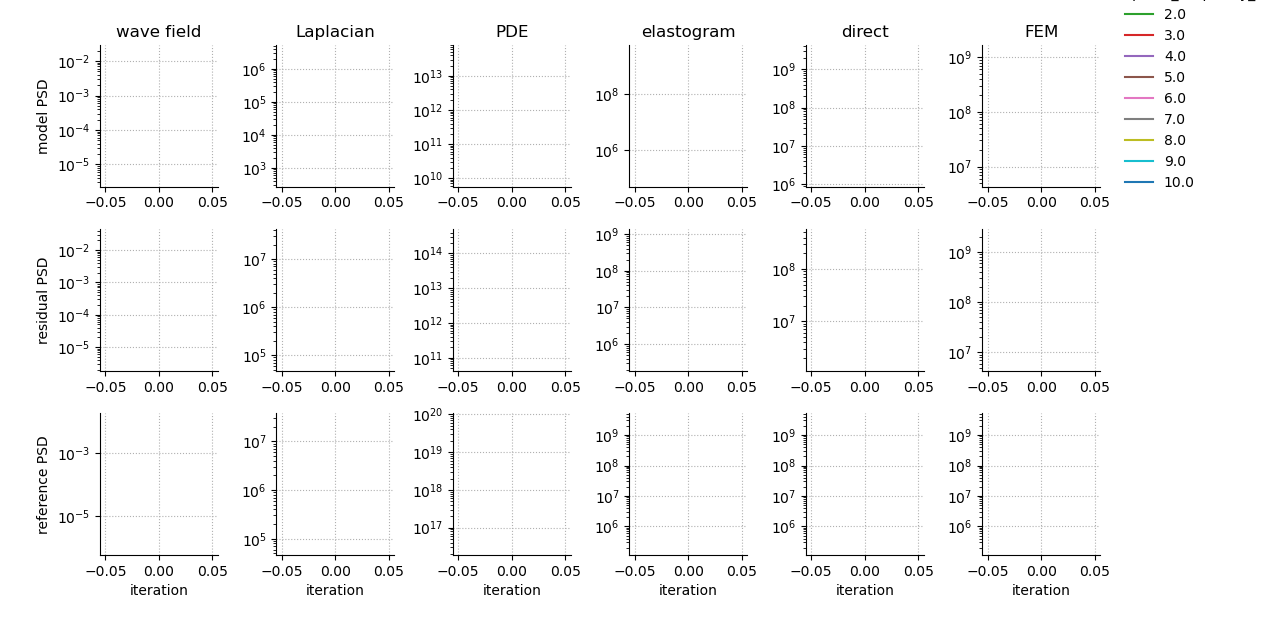

<IPython.core.display.Javascript object>


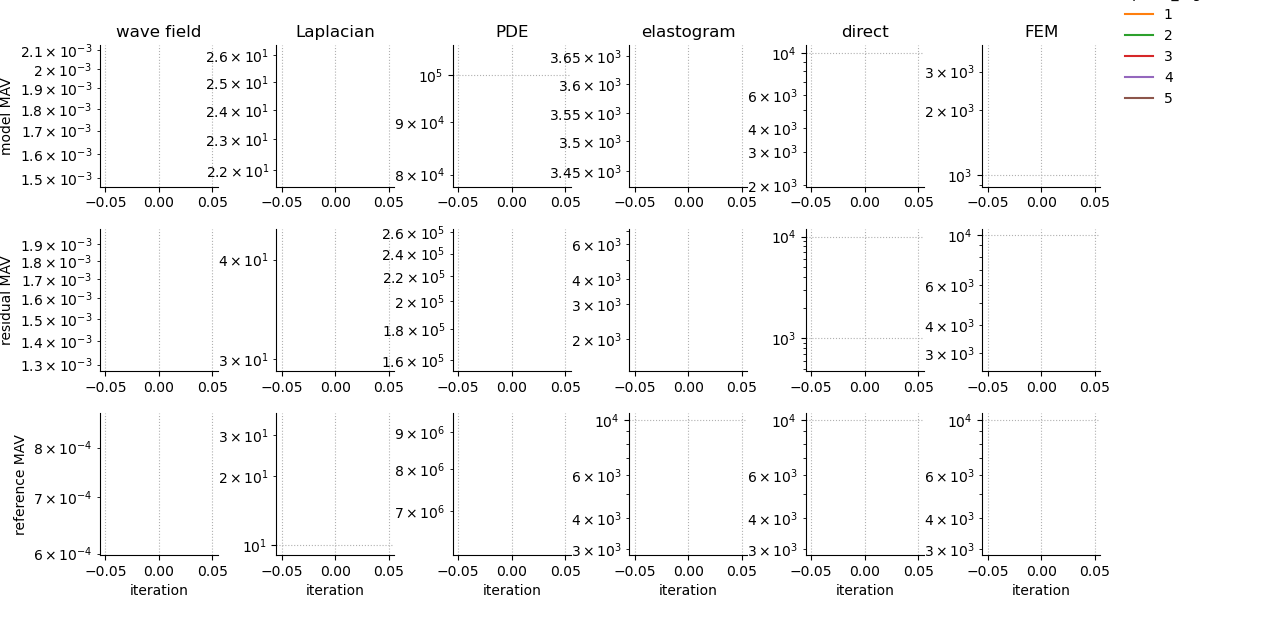

<IPython.core.display.Javascript object>


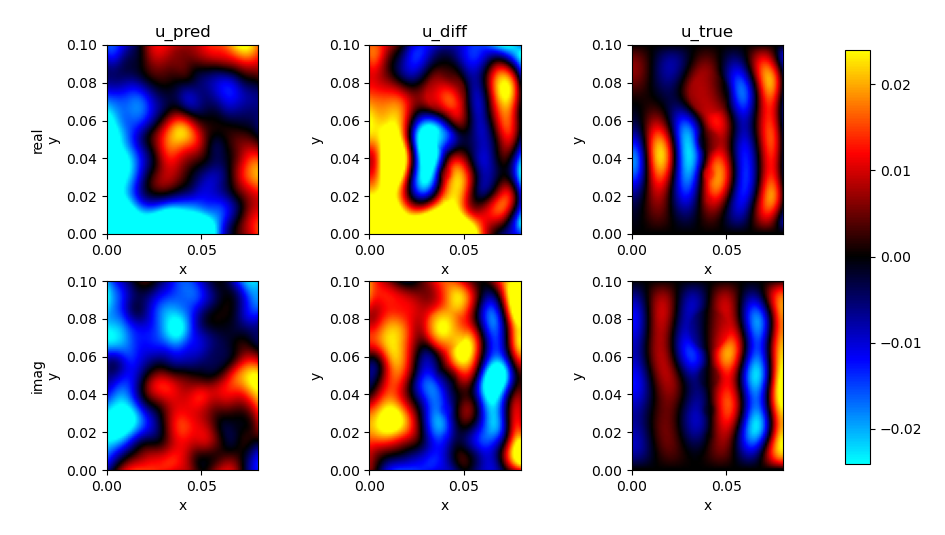

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


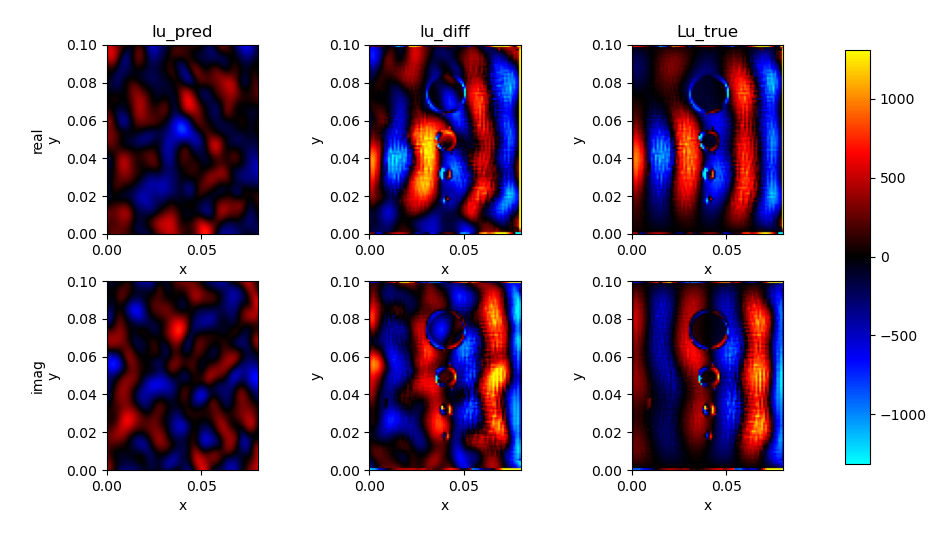

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


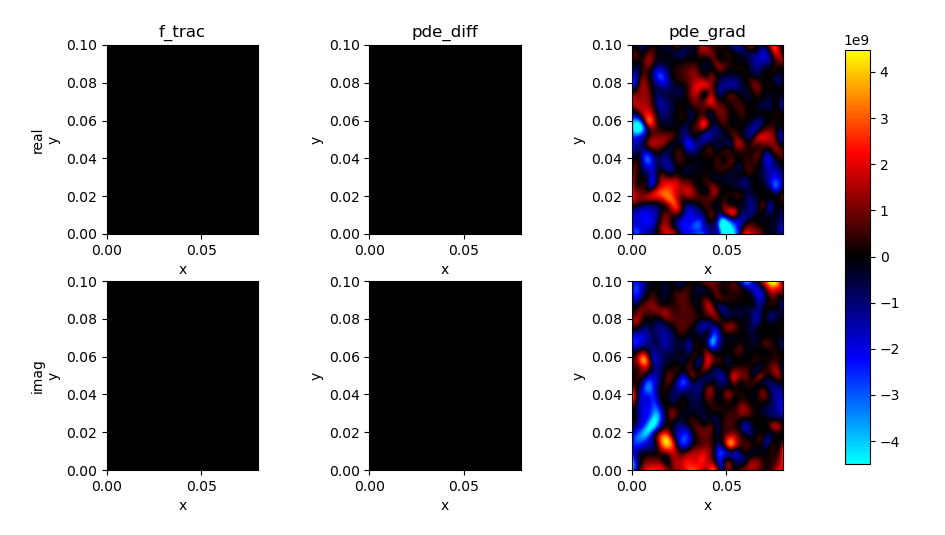

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


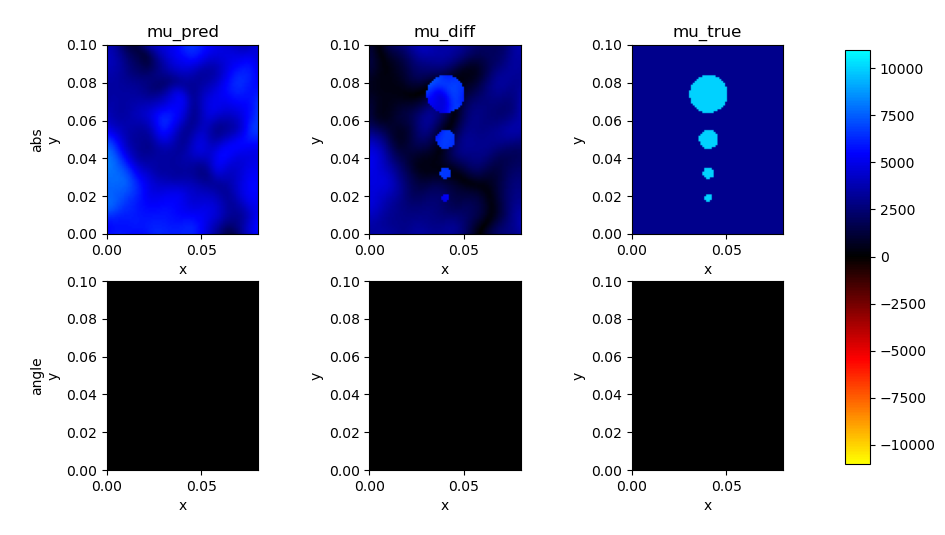

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


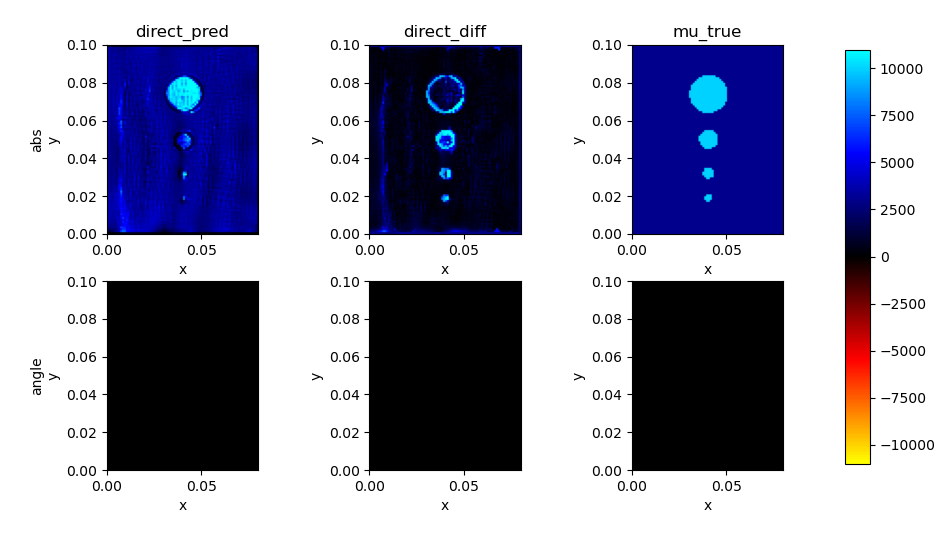

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


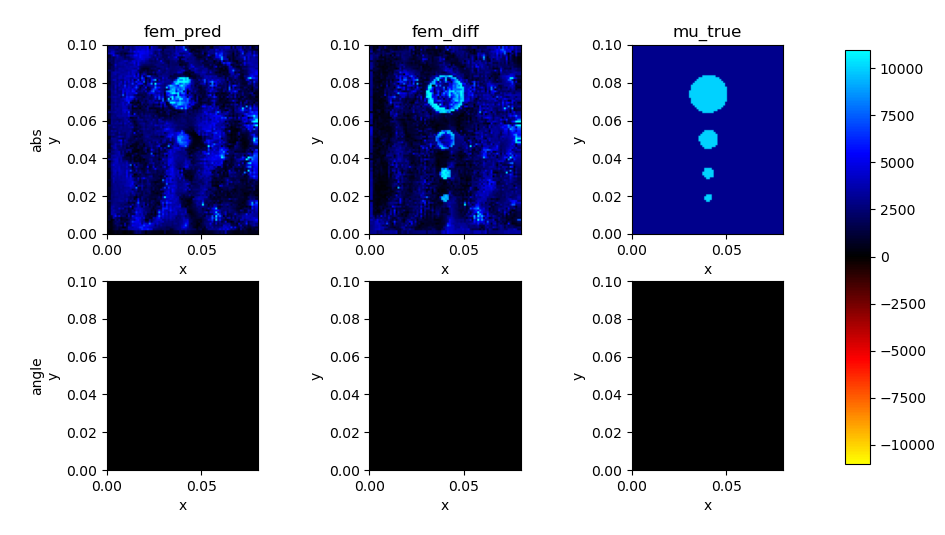

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

In [94]:
%autoreload
test_eval = mre_pinn.testing.TestEvaluator(test_every=100, interact=True)
test_eval.model = model
test_eval.test()

In [ ]:
model.train(100000, display_every=10, callbacks=[test_eval])

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.71e-04, 0.00e+00, 0.00e+00]    [1.74e-04, 0.00e+00, 0.00e+00]    []  
